In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
data=pd.read_csv('heart_disease_uci.csv')
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
num_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
cat_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']
bool_cols = ['fbs', 'exang']
data[bool_cols] = data[bool_cols].replace({0: 'FALSE', 1: 'TRUE'})

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), cat_cols)
    ]
)
data['num']=(data['num']>0).astype(int)
X = preprocess.fit_transform(data.drop('num', axis=1))
y = data['num'].values


In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [6]:
def compute_cost(X, y, w, b,lambda_=1):
    m, n = X.shape
    cost = 0
    epsilon = 1e-15 # small value to avoid log(0)
    for i in range(0,m):
        z=np.dot(w,X[i])+b
        f_wb=sigmoid(z)
        loss = - (y[i]*np.log(f_wb+epsilon) + (1-y[i])*np.log(1-f_wb+epsilon))
        cost=cost+loss
    total_cost=cost/(m)
    for j in range(0,n):
        total_cost=total_cost+(lambda_/(2*m))*(w[j]**2)
    return total_cost

In [7]:
def compute_gradient(X, y, w, b, lambda_=0):
    m, n = X.shape
    dj_dw = np.zeros(n)
    dj_db = 0.0
    for i in range(m):
        z = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z)
        err = f_wb_i - y[i]
        for j in range(n):
            dj_dw[j] += err * X[i, j]
        dj_db += err
    dj_db = dj_db / m
    dj_dw = dj_dw / m
    for j in range(n): 
        dj_dw[j] = dj_dw[j] + (lambda_/m)*w[j]
    return dj_db, dj_dw

In [8]:
def predict_tip(w,b,X):
    m,n = X.shape
    p=np.zeros(m)
    for i in range(m):
        z = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z)
        p[i] = 1 if f_wb_i >= 0.5 else 0
    return p

In [ ]:
m, n = X.shape
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X, y, initial_w, initial_b)
print('Cost at initial w and b (zeros): {:.3f}'.format(cost))


Cost at initial w and b (zeros): 0.693
920
15


In [10]:
def gradient_function(X, y, w_in, b_in, lambda_)  :
    m,n = X.shape
    dj_db, dj_dw = compute_gradient(X, y, w_in, b_in, lambda_)
    return dj_db, dj_dw

In [11]:
initial_w = np.zeros(n)
initial_b = 0.
dj_db, dj_dw = compute_gradient(X, y, initial_w, initial_b)
print('Gradient at initial w and b (zeros) - dj_db: {:.3f}, dj_dw: {}'.format(dj_db, dj_dw))

Gradient at initial w and b (zeros) - dj_db: -0.053, dj_dw: [-0.14054556 -0.05034862  0.11383653  0.18984557 -0.1820276  -0.10434783
  0.06847826  0.03152174  0.00326087 -0.00923913 -0.03097826 -0.05978261
  0.02554348  0.02282609 -0.06304348]


In [12]:
import math
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_=0.0): 
    m = len(X)
    J_history = []
    w_history = []
    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
        if i<100000: 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
    return w_in, b_in, J_history, w_history

In [72]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
np.random.seed(1)
tf.random.set_seed(1)
initial_w = np.random.randn(n)
initial_b = 0.
interations=10000
alpha = 0.001

X_train, X_test, y_train, y_test = train_test_split(
   X, y, 
    stratify=y,
    test_size=0.2,
    random_state=42
)
X_train_scaled = (X_train - np.mean(X, axis=0)) / np.std(X_train, axis=0) # z-score normalization( z=(x-u)/ơ, np.mean(X_train, axis=0)->u, np.std(X_train, axis=0)->ơ )

w,b, J_history, w_history = gradient_descent(X_train_scaled, y_train, initial_w, initial_b, compute_cost, compute_gradient,
                                   alpha, interations, 1.0)

Iteration    0: Cost     1.78   
Iteration 1000: Cost     1.52   
Iteration 2000: Cost     1.31   
Iteration 3000: Cost     1.15   
Iteration 4000: Cost     1.02   
Iteration 5000: Cost     0.92   
Iteration 6000: Cost     0.83   
Iteration 7000: Cost     0.77   
Iteration 8000: Cost     0.72   
Iteration 9000: Cost     0.67   
Iteration 9999: Cost     0.64   


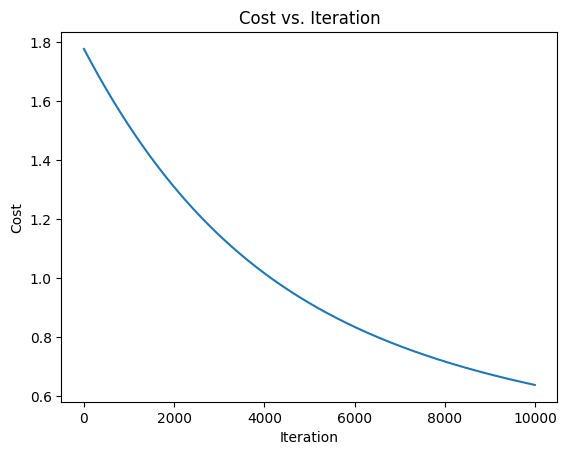

In [73]:
plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost vs. Iteration")
plt.show()

In [74]:
print(w)
print(b)

[ 0.99199171 -0.32196154 -0.57859962 -1.09234307  1.05562141 -0.43772904
  0.00858572 -0.48762763 -0.08490825  0.20089225  0.79385506 -1.04069025
 -1.07553779 -0.30465748  0.85433407]
0.3700726616401443


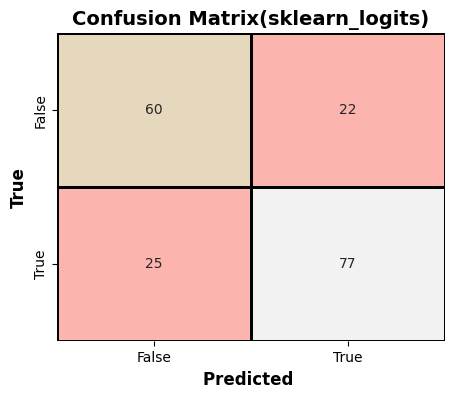

In [169]:
# z=np.array([[52,0,3,136,196,0,2,169,0,0.1,2,0,3]])
# z=(z - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
# print(predict_tip(w,b,z))
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

mean_train = np.mean(X_train, axis=0)
std_train = np.std(X_train, axis=0)
X_test_scale = (X_test - mean_train) / std_train
# confusion matrix
y_pred=predict_tip(w,b,X_test_scale)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Pastel1",   
    cbar=False,
    linewidths=1,
    linecolor="black",
    xticklabels=["False", "True"],
    yticklabels=["False", "True"]
)

plt.xlabel("Predicted ", fontsize=12, fontweight="bold")
plt.ylabel("True", fontsize=12, fontweight="bold")
plt.title("Confusion Matrix(sklearn_logits)", fontsize=14, fontweight="bold")

plt.show()


In [76]:
p= predict_tip(w, b, X_train_scaled)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))
print('cost', J_history[-1])

Train Accuracy: 73.913043
cost 0.6380510889236477


In [77]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [78]:
print('Train Accuracy sklearn: %f'%(model.score(X_test, y_test) * 100))
print('cost',compute_cost(X_train_scaled, y, model.coef_[0], model.intercept_[0]))

Train Accuracy sklearn: 82.065217
cost 1.5702801828015995


In [79]:
from sklearn.linear_model import LogisticRegressionCV
model_cv = LogisticRegressionCV(max_iter=10000)
model_cv.fit(X_train, y_train)

,Cs,10
,fit_intercept,True
,cv,None
,dual,False
,penalty,'l2'
,scoring,None
,solver,'lbfgs'
,tol,0.0001
,max_iter,10000
,class_weight,None
,n_jobs,None


In [80]:
print(model_cv.score(X_test, y_test)*100)
print(compute_cost(X_train_scaled, y, model_cv.coef_[0], model_cv.intercept_[0]))

82.6086956521739
1.0695350952836853


In [81]:
# lấy feature names(Ai)
num_features = num_cols
cat_features = preprocess.named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_features, cat_features])
importance = np.abs(model.coef_[0])

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(10)


,Feature,Importance
6,cp_atypical angina,1.968887
7,cp_non-anginal,1.236616
8,cp_typical angina,1.193775
5,sex_Male,1.066070
11,slope_flat,0.704734
4,oldpeak,0.664741
13,thal_normal,0.575770
14,thal_reversable defect,0.398903
3,thalch,0.372920
0,age,0.354797


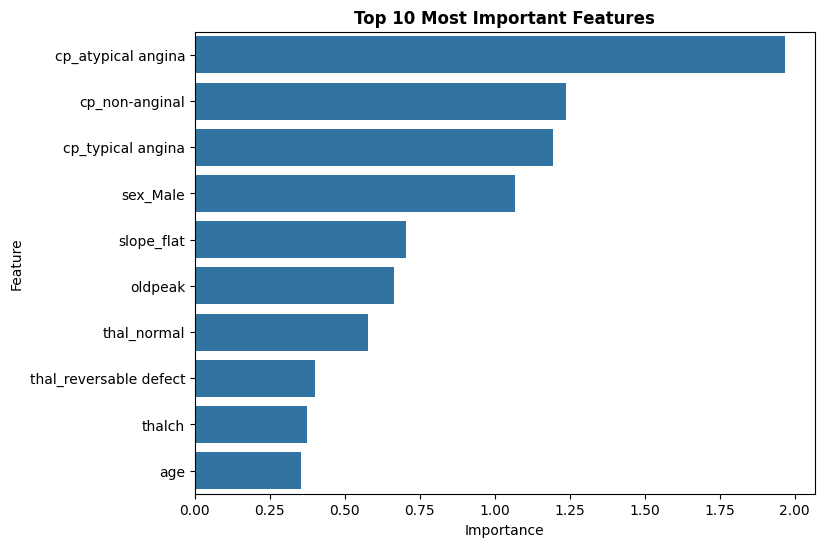

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
#(ai)
plt.figure(figsize=(8,6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(10)
)
plt.title("Top 10 Most Important Features", fontweight='bold')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


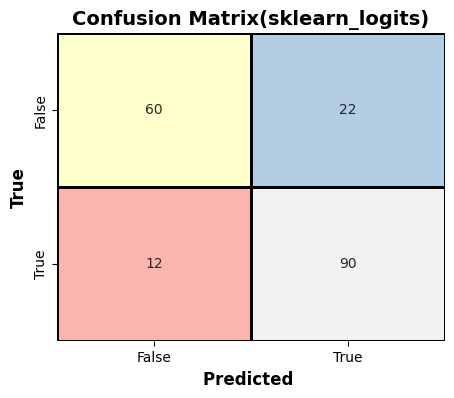

In [170]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred=model_cv.predict(X_test_scale)
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Pastel1",   
    cbar=False,
    linewidths=1,
    linecolor="black",
    xticklabels=["False", "True"],
    yticklabels=["False", "True"]
)

plt.xlabel("Predicted ", fontsize=12, fontweight="bold")
plt.ylabel("True", fontsize=12, fontweight="bold")
plt.title("Confusion Matrix(sklearn_logits)", fontsize=14, fontweight="bold")

plt.show()


In [171]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # pyright: ignore[reportMissingImports]
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
tf.config.run_functions_eagerly(True)
m,n = X.shape
model_tfuci = Sequential([
    Dense(128,name='layer1' ,activation='relu',
                          kernel_initializer='he_normal',
                          input_shape=(X.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.20),

    Dense(64, name='layer2', activation='relu',
                          kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.20),

    Dense(32, name='layer3', activation='relu'),
    tf.keras.layers.Dropout(0.10),

    Dense(1, name='output_layer',activation='linear')
])
#Dense - BatchNorm - ReLU - Dropout
#Dropout giảm dần theo từng layer(tắt ngẫu nhiên neuron khi TRAINING để tránh overfitting)
model_tfuci.summary()


c:\Users\LOQ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [174]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
tf.config.run_functions_eagerly(False)
np.random.seed(1)
tf.random.set_seed(1)
X_train_val, X_test, y_train_val, y_test = train_test_split(
   X, y, 
    stratify=y,
    test_size=0.2,
    random_state=42
)
X_train,X_val,y_train,y_val=train_test_split(
    X_train_val,y_train_val,
    test_size=0.25,
    random_state=42,
    stratify=y_train_val
)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=3e-4,
    clipnorm=1.0   # chống exploding gradient
)
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight = dict(enumerate(weights))

model_tfuci.compile(
    optimizer=optimizer,
    loss=BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)#để dừng sớm tránh overfit

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-5
)#giảm learing_rate khi đến epoch nhất định
model_tfuci.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early,reduce_lr],
    verbose=1,
    class_weight=class_weight
)
logit=model_tfuci(X_test)
f_x=tf.nn.sigmoid(logit)
loss, acc = model_tfuci.evaluate(X_test, y_test, verbose=0)
print(f" Accuracy NN  {acc*100:.2f}%")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7917 - loss: 0.4257 - val_accuracy: 0.7663 - val_loss: 0.4859 - learning_rate: 3.0000e-04
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7971 - loss: 0.4173 - val_accuracy: 0.7663 - val_loss: 0.4852 - learning_rate: 3.0000e-04
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7953 - loss: 0.4289 - val_accuracy: 0.7554 - val_loss: 0.4856 - learning_rate: 3.0000e-04
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8025 - loss: 0.4238 - val_accuracy: 0.7500 - val_loss: 0.4851 - learning_rate: 3.0000e-04
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8134 - loss: 0.4011 - val_accuracy: 0.7391 - val_loss: 0.4847 - learning_rate: 3.0000e-04
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7989 - loss: 0.3993 - val_accuracy: 0.7391 - val_loss: 0.4856 - learning_rate: 3.0000e-04
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8025

In [175]:
w_nn,b_nn=model_tfuci.get_layer('output_layer').get_weights()
print('Weights:', w_nn)    
print('Bias:', b_nn)

Weights: [[-0.28119895]
 [ 0.24737975]
 [-0.20735537]
 [ 0.04401703]
 [ 0.09397505]
 [-0.23964871]
 [ 0.41026807]
 [ 0.19950531]
 [-0.27373242]
 [ 0.16421552]
 [ 0.08004342]
 [ 0.04444293]
 [-0.213217  ]
 [-0.28737482]
 [-0.24474083]
 [ 0.3003491 ]
 [ 0.03474779]
 [ 0.11141003]
 [ 0.18197352]
 [-0.09309681]
 [ 0.34225422]
 [-0.39398906]
 [-0.09138788]
 [ 0.15752661]
 [-0.11736277]
 [ 0.34703726]
 [ 0.28992602]
 [-0.14238882]
 [ 0.38315997]
 [-0.17460382]
 [-0.40891534]
 [-0.30049825]]
Bias: [0.00770778]


In [176]:
import numpy as np
from sklearn.metrics import f1_score

# 1. Lấy xác suất trên tập VALIDATION
logit_val = model_tfuci.predict(X_val)
probs_val = tf.nn.sigmoid(logit_val).numpy()

# 2. Tạo một danh sách các ngưỡng thử nghiệm (từ 0.01 đến 0.99)
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_temp = (probs_val >= t).astype(int)
    f1 = f1_score(y_val, y_pred_temp)
    f1_scores.append(f1)

# 3. Tìm ngưỡng có F1 cao nhất
best_ix = np.argmax(f1_scores)
best_thresh = thresholds[best_ix]

print(f'Best Threshold: {best_thresh:.2f}')
print(f'Max F1-Score trên Validation: {f1_scores[best_ix]:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Best Threshold: 0.45
Max F1-Score trên Validation: 0.8037


In [177]:

# default >0.5 ->1
z=np.array([67,'Male','asymptomatic',160,286,'FALSE','lv hypertrophy',108,'TRUE',1.5,'flat',3,'normal'])
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
z_df = pd.DataFrame([z], columns=columns)
z_processed = preprocess.transform(z_df)
logit = model_tfuci.predict(z_processed)
f_x=tf.nn.sigmoid(logit).numpy()
y_pred = (f_x >= best_thresh).astype(int)
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[1]]


In [ ]:
from sklearn.metrics import classification_report
logit = model_tfuci.predict(X_test)
y_prob_nn = tf.nn.sigmoid(logit).numpy() 
y_pred_nn = (y_prob_nn >= best_thresh).astype(int) 
print(classification_report(y_test,y_pred_nn))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.90      0.73      0.81        82
           1       0.81      0.93      0.87       102

    accuracy                           0.84       184
   macro avg       0.85      0.83      0.84       184
weighted avg       0.85      0.84      0.84       184



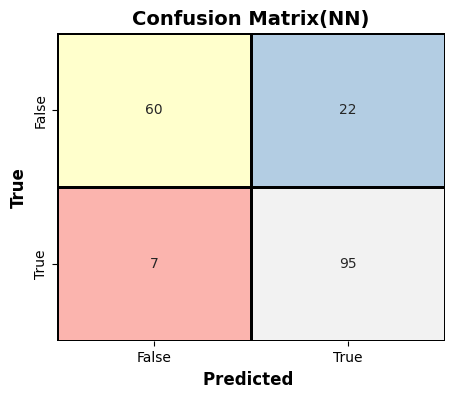

In [185]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(5, 4))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Pastel1",   
    cbar=False,
    linewidths=1,
    linecolor="black",
    xticklabels=["False", "True"],
    yticklabels=["False", "True"]
)

plt.xlabel("Predicted ", fontsize=12, fontweight="bold")
plt.ylabel("True", fontsize=12, fontweight="bold")
plt.title("Confusion Matrix(NN)", fontsize=14, fontweight="bold")

plt.show()
